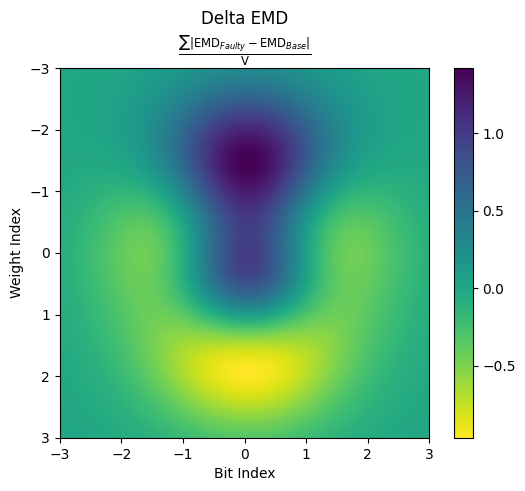

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Mathematical function we need to plot
def z_func(x, y):
    return (1 - (x ** 2 + y ** 3)) * np.exp(-(x ** 2 + y ** 2) / 2)

# Setting up input values
x = np.arange(-3.0, 3.0, 0.1)
y = np.arange(-3.0, 3.0, 0.1)
X, Y = np.meshgrid(x, y)

# Calculating the output and storing it in the array Z
Z = z_func(X, Y)

im = plt.imshow(Z, cmap=plt.cm.viridis_r, extent=(-3, 3, 3, -3),
                interpolation='bilinear')

plt.colorbar(im)
plt.title('Delta EMD\n$\\frac{\sum{}{}|\mathrm{EMD}_{Faulty} - \mathrm{EMD}_{Base}|}{\mathrm{V}}$')
plt.xlabel("Bit Index")
plt.ylabel("Weight Index")
plt.show()

In [2]:
# Dataset Source is:
# https://emdhgcalae.nrp-nautilus.io/ttbar/data/HGCal22Data_signal_driven_ttbar_v11/nElinks_5/5Elinks_data.csv
# 
# Each line of efr.log is structured as follows:
# (val_i, bit_i) | emd_val
# val_i is the index of the validation input (i.e., physics event) passed to the auto encoder
# bit_i is the index of the bit that has been flipped (i.e., the location of the where the single fault was injected)
# emd_val is the emd value computed for the result of the indicated faulty model on the indicated validation input
#
# It should be noted that baseline_efr.log contains the emd values computed for the results of the non-faulty model on the indicated validation inputs
# The bit_i field can be ignored for this file since no bits were flipped.  
b_efr_f = open("./baseline_efr.log", "r")
v_efr_f = open("./efr.log", "r")

b_efr_f.close()
v_efr_f.close()

In [3]:
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1uAtPKDwQDOBvJypMOX0DQoHojNMSSkct' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1uAtPKDwQDOBvJypMOX0DQoHojNMSSkct" -O efr_feb_15_2023_02.log && rm -rf /tmp/cookies.txt

In [4]:
with open("/home/anmeza/GitHub/fastml-science/sensor-data-compression/baseline_efr.log") as f:
    print(f.readlines()[-10:])

['(809992,0) | 1.712364529694073933541176302242092788219451904296875\n', '(809993,0) | 1.824777575499223036814555598539300262928009033203125\n', '(809994,0) | 0.653049699001781558393986415467225015163421630859375\n', '(809995,0) | 1.158759508254781689373658082331530749797821044921875\n', '(809996,0) | 1.169021440513150711382195368059910833835601806640625\n', '(809997,0) | 1.3321750473918994028821316533139906823635101318359375\n', '(809998,0) | 1.792855069026018544064982052077539265155792236328125\n', '(809999,0) | 1.3242323885469975408568643615581095218658447265625\n', '(810000,0) | 0.7315876424136964484290501786745153367519378662109375\n', '(810001,0) | 1.1614762997871450611597765600890852510929107666015625\n']


In [4]:
num_lines = 0

bi_to_demd  = dict()
bi_to_count = dict()

print("Summing EMD values for each bit")
with open("/home/anmeza/GitHub/fastml-science/sensor-data-compression/efr_val_inputs_0-31_with_eager_exec.log") as f:
    for li, line in enumerate(f):
        if li > 0:
            try:
                curr_vi_bi, curr_emd = [substr.strip() for substr in line.split("|")]
                vi, bi = [int(val) for val in curr_vi_bi[1:-1].split(",")]
                num_lines += 1
                try:
                    bi_to_demd[bi]  += float(curr_emd)
                    bi_to_count[bi] += 1
                except KeyError:
                    bi_to_demd[bi]  = float(curr_emd)
                    bi_to_count[bi] = 1
                    #print(f"New bi from {curr_vi_bi} at line number: {li}")
            except ValueError:
                pass #print(line)
        # if len(bi_to_demd.keys()) == 10000:
        #     break 


print("Averaging EMD values for each bit")
for bi in bi_to_demd.keys():
    bi_to_demd[bi]  = bi_to_demd[bi]/bi_to_count[bi]

print(num_lines)

Summing EMD values for each bit
Averaging EMD values for each bit
339168


In [5]:
def get_wi(i_bi, i_bw):
    return int(i_bi/i_bw)

def get_wbi(i_bi, i_bw):
    return int(i_bi%i_bw)


wis  = list()
bis  = list()
demd = list()

for bi in bi_to_demd.keys():
    wis.append(get_wi(bi,5))
    bis.append(get_wbi(bi,5))
    if get_wbi(bi,5) == 0:
        demd.append(bi_to_demd[bi]) #demd.append(1.6)
    else:
        demd.append(bi_to_demd[bi])

    # if len(wis) == 1970:
    #     break

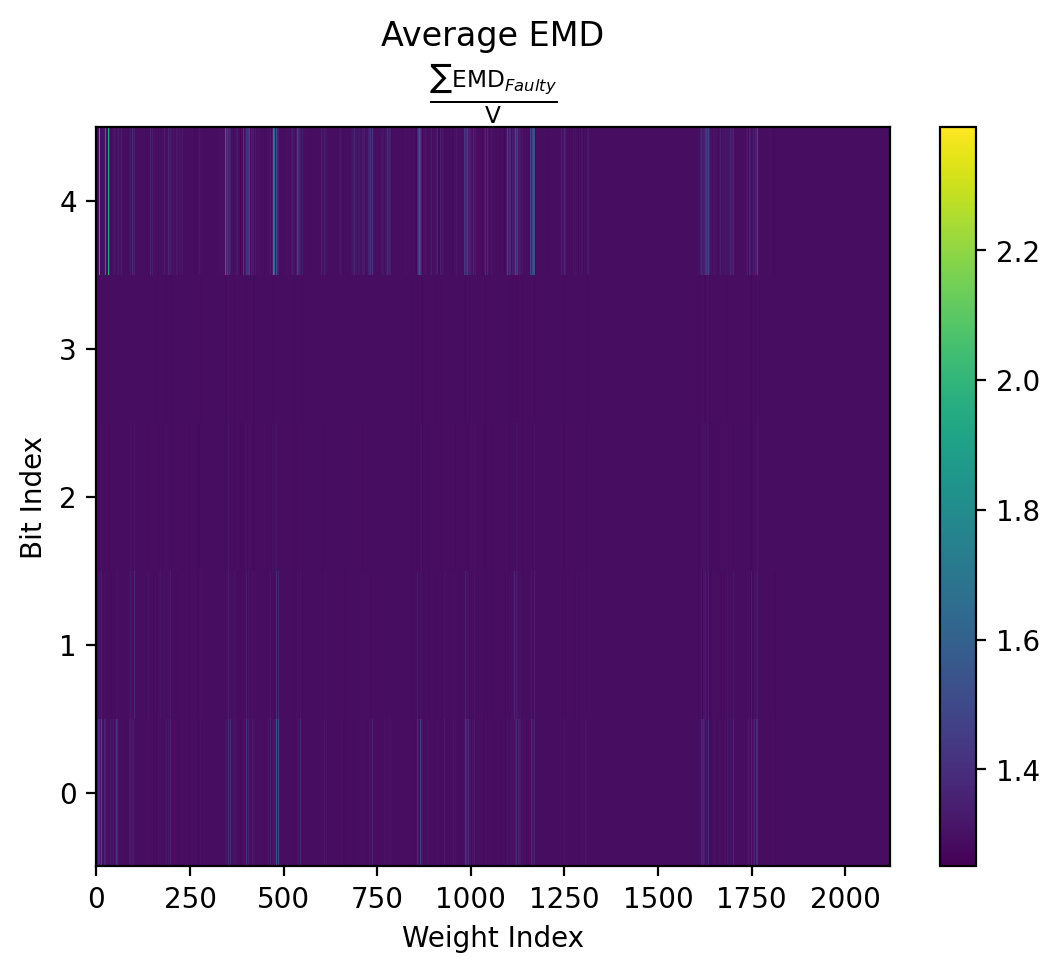

In [6]:
'''
https://gist.github.com/teechap/9c066a9ab054cc322877
Most heatmap tutorials I found online use pyplot.pcolormesh with random sets of
data from Numpy; I just needed to plot x, y, z values stored in lists--without
all the Numpy mumbo jumbo. Here I have code to plot intensity on a 2D array, and
I only use Numpy where I need to (pcolormesh expects Numpy arrays as inputs).
'''
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'

#here's our data to plot, all normal Python lists
y = sorted(list(set(bis))) #[1, 2, 3, 4, 5]
x = sorted(list(set(wis)))            #[0.1, 0.2, 0.3, 0.4, 0.5]

# intensity = [
#     [5, 10, 15, 20, 25],
#     [30, 35, 40, 45, 50],
#     [55, 60, 65, 70, 75],
#     [80, 85, 90, 95, 100],
#     [105, 110, 115, 120, 125]
# ]

intensity = list()
for wi in sorted(list(set(wis))):
    rel_demds = demd[wi*5:(wi+1)*5] 
    if len(rel_demds) < 5:
        rel_demds += [1.4 for _ in range(5-len(rel_demds))]
    intensity.append(rel_demds)

# intensity[0][0] = 25

#setup the 2D grid with Numpy
x, y = np.meshgrid(x, y)

#convert intensity (list of lists) to a numpy array for plotting
intensity = np.array(intensity).transpose()

#now just plug the data into pcolormesh, it's that easy!
plt.pcolormesh(x, y, intensity)
plt.colorbar() #need a colorbar to show the intensity scale
# plt.title('Delta EMD\n$\\frac{\sum{}{}|\mathrm{EMD}_{Faulty} - \mathrm{EMD}_{Base}|}{\mathrm{V}}$')
plt.title('Average EMD\n$\\frac{\sum{}{}\mathrm{EMD}_{Faulty}}{\mathrm{V}}$')
plt.ylabel("Bit Index")
plt.xlabel("Weight Index")
# plt.rcParams["figure.figsize"] = (,3)
# plt.xlim(0,60)
plt.show() #boom

In [7]:
max(bi_to_demd.keys())

10599

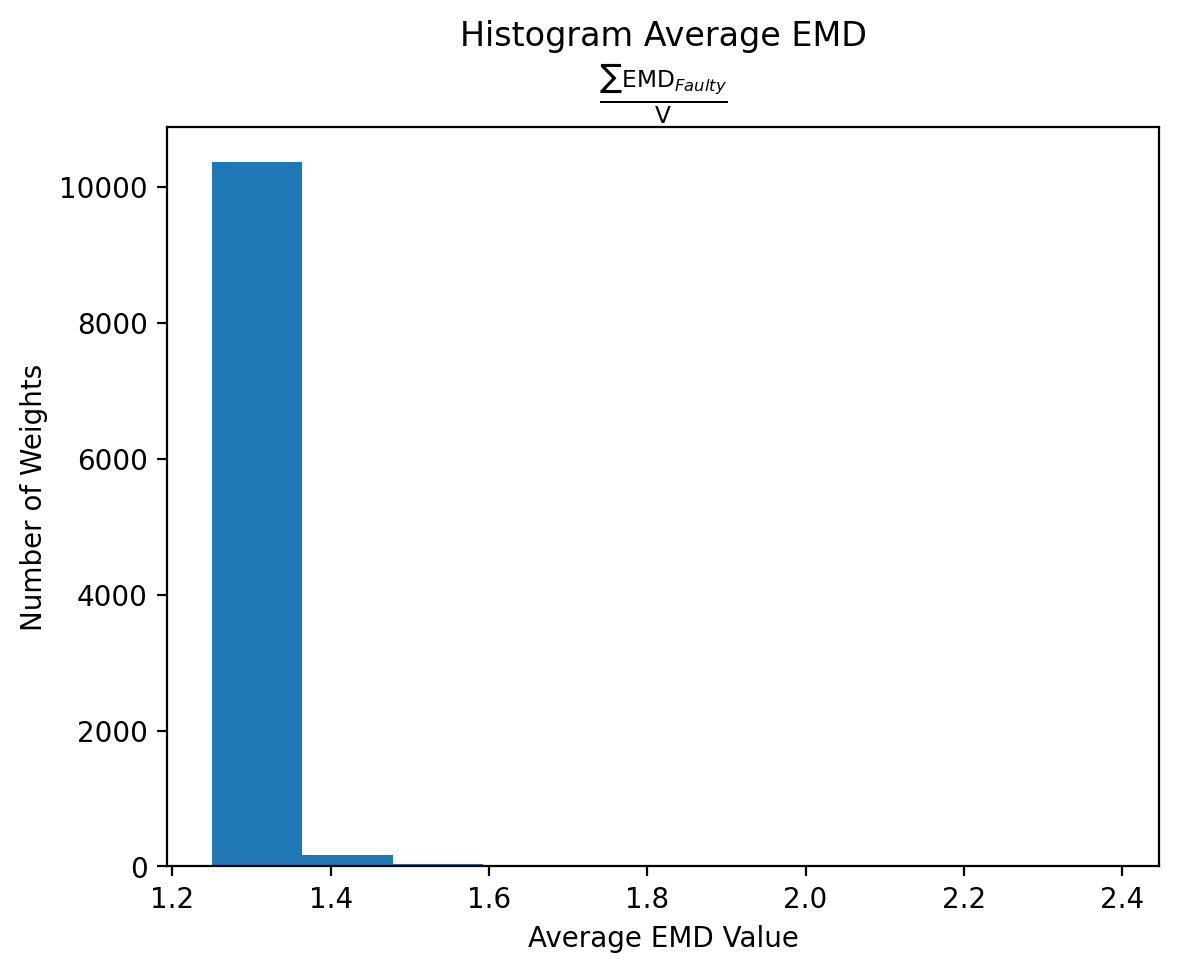

In [8]:
plt.hist(bi_to_demd.values())
plt.title('Histogram Average EMD\n$\\frac{\sum{}{}\mathrm{EMD}_{Faulty}}{\mathrm{V}}$')
plt.ylabel("Number of Weights")
plt.xlabel("Average EMD Value")
plt.show()

In [9]:
intensity

array([[1.57564968, 1.79981479, 1.57503645, ..., 1.28723971, 1.28723971,
        1.28723971],
       [1.32761686, 1.35861766, 1.34215906, ..., 1.28723971, 1.28723971,
        1.28723971],
       [1.30599712, 1.30175489, 1.29628064, ..., 1.28723971, 1.28723971,
        1.28723971],
       [1.28860508, 1.30392984, 1.28755199, ..., 1.28723971, 1.28723971,
        1.28723971],
       [2.38962447, 1.29238392, 1.28177149, ..., 1.28723971, 1.28723971,
        1.4       ]])

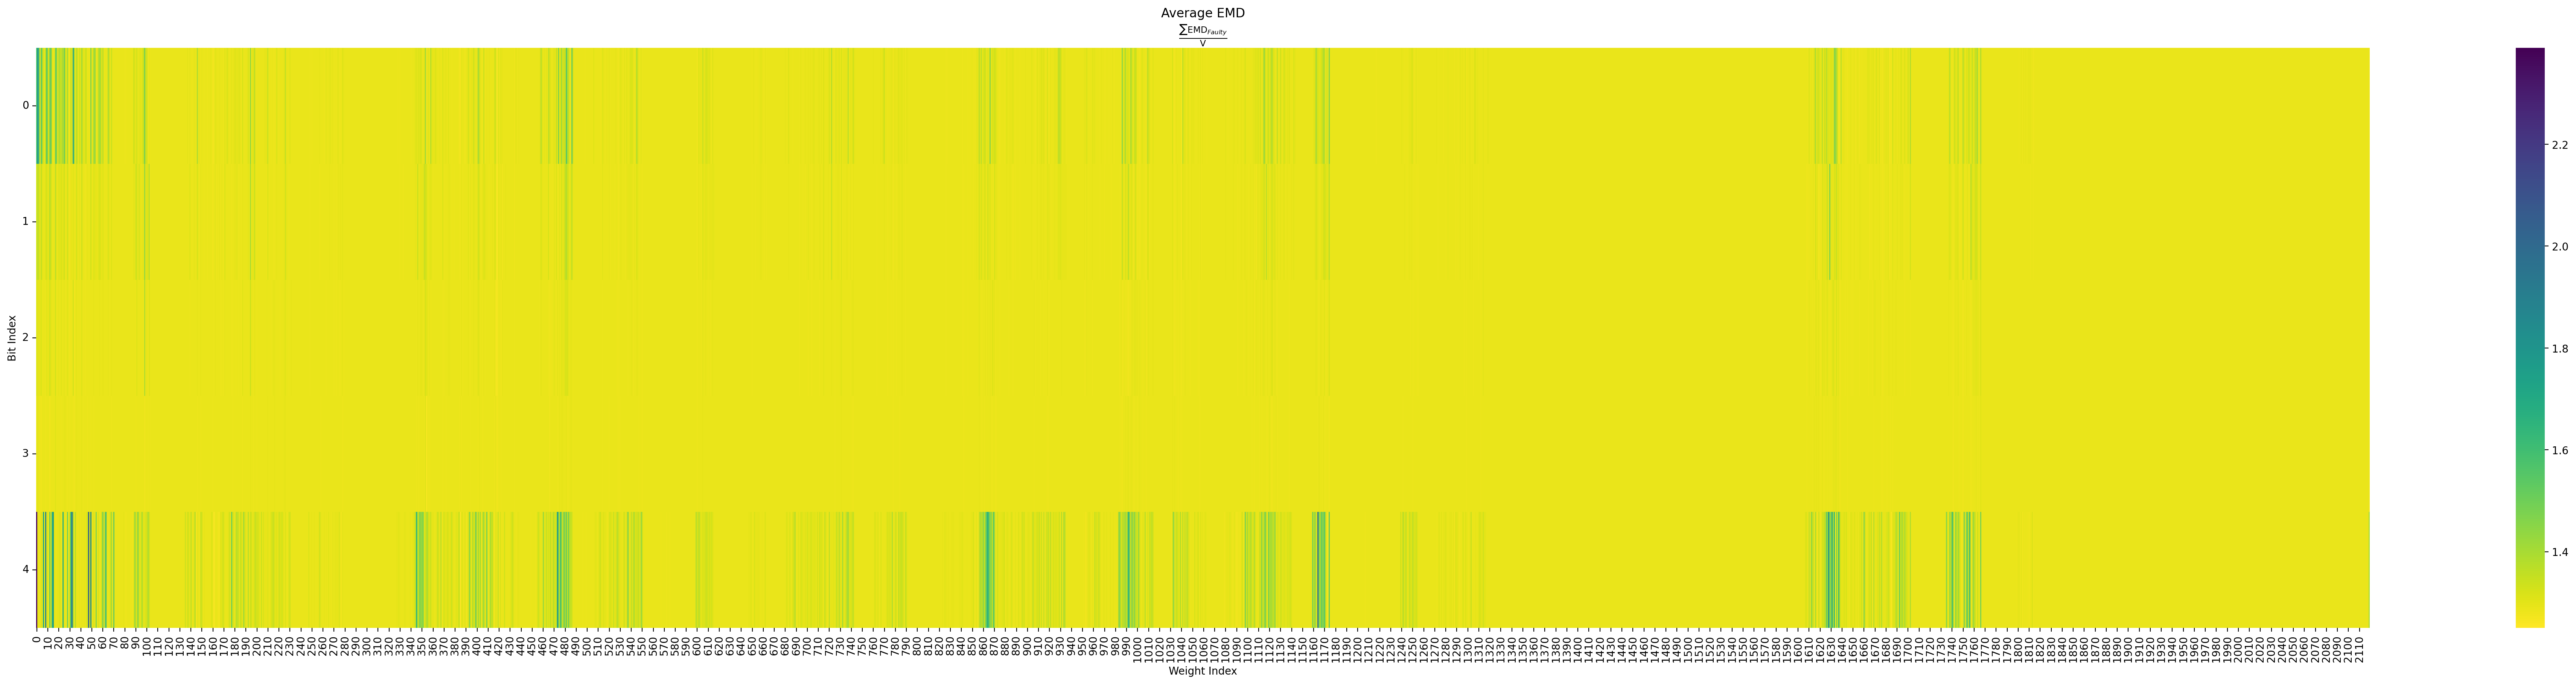

In [10]:
import seaborn as sns
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format='retina'
np.set_printoptions(suppress=True)

fig, ax = plt.subplots(figsize=(50,10))         # Sample figsize in inches
# sns.heatmap(df1.iloc[:, 1:6:], annot=True, linewidths=.5, ax=ax)
sns.heatmap(intensity, annot=False, fmt="f", ax=ax, cmap="viridis_r", square=False, vmin=intensity.min(), vmax=intensity.max())
plt.yticks(rotation=0) 
# title =   f"Distribution of {curr_c}x{curr_p} " + "ACMs based on # of $UP_{read}$ & $UP_{write}$"
# plt.title(title)
# plt.xlabel("Number of $UP_{write}$ Scenarios Present in ACM")
# plt.ylabel("Number of $UP_{read}$ Scenarios  Present in ACM")
plt.title('Average EMD\n$\\frac{\sum{}{}\mathrm{EMD}_{Faulty}}{\mathrm{V}}$')
plt.ylabel("Bit Index")
plt.xlabel("Weight Index")
plt.savefig(f"EMD_HEATMAP.svg")
plt.show()

In [39]:
intensity.shape

(5, 1899)

2.389624469202137

In [12]:
pal = sns.color_palette("flare", as_cmap=True, )
pal(0.5)

i_min = intensity.min()
i_max = intensity.max()
i_range = i_max-i_min

with open("temp_hmap.js", "w") as f:
    # f.write("const rows = [")
    # for r in range(intensity.shape[0]):
    #     for c in range(intensity.shape[1]):
    #         v = intensity[r,c]

    #         f.write(f"{r},")
    # f.write("];\n")

    # f.write("const cols = [")
    # for r in range(intensity.shape[0]):
    #     for c in range(intensity.shape[1]):
    #         v = intensity[r,c]

    #         f.write(f"{c},")
    # f.write("];\n")

    f.write("const vals = [")
    for r in range(intensity.shape[0]):
        for c in range(intensity.shape[1]):
            v = intensity[r,c]

            f.write(f"{v},")
    f.write("];\n")

#     f.write("const clrs = [")
#     for r in range(intensity.shape[0]):
#         for c in range(intensity.shape[1]):
#             v = intensity[r,c]
#             norm_v = (v-i_min)/i_range

#             f.write(f"{list(pal(norm_v))},")
#     f.write("];\n")

#     f.write('''
# var pxl_h = 40;
# var pxl_w = 40;

# // for (const [key, value] of myMap) {
# //   console.log(`${key} = ${value}`);
# // }

# function update_info_div(i_info_id, i_row, i_col, i_val) {
#   const info_div = document.getElementById(i_info_id);
#   info_div.textContent = 'val: ' + i_val;
# }

# function build_heatmap(
#   i_container_id,
#   i_rows,
#   i_cols,
#   i_vals,
#   i_clrs,
#   i_info_id
# ) {
#   const container = document.getElementById(i_container_id);
#   const info_div = document.getElementById(i_info_id);

#   for (let i = 0; i < i_rows.length; i++) {
#     var pixel = document.createElement('DIV');
#     pixel.style.height = pxl_w + 'px';
#     pixel.style.width = pxl_w + 'px';
#     pixel.style.position = 'absolute';
#     pixel.style.top = i_rows[i] * pxl_h + 'px';
#     pixel.style.left = i_cols[i] * pxl_w + 'px';

#     const color = i_clrs[i];
#     const r = Math.floor(color[0] * 255);
#     const g = Math.floor(color[1] * 255);
#     const b = Math.floor(color[2] * 255);

#     pixel.style.backgroundColor = `rgba(${r}, ${g}, ${b}, 1.0)`; //'#deadbeef'; //+ i_vals[i].toString(16);
#     container.appendChild(pixel);

#     pixel.row = i_rows[i];
#     pixel.col = i_cols[i];
#     pixel.val = i_vals[i];
#     pixel.info = i_info_id;

#     pixel.addEventListener('mouseover', (event) => {
#       // console.log(event.target);
#       // const info_div = document.getElementById(event.target.info);
#       info_div.textContent = `(w,b,v) = (${i_rows[i]}, ${i_cols[i]}, ${i_vals[i]})`;
#     });
#   }
# }

# window.addEventListener('load', (event) => {
#   build_heatmap('heatmap', rows, cols, vals, clrs, 'mouse_info');
# });''')

In [16]:
pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 3.3 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [25]:
for cbi, cdemd in bi_to_demd.items():
    if cdemd == 1.5941759409650014:
        print(f"(bi, wi, wbi) = ({cbi}, {get_wi(cbi,5)}, {get_wbi(cbi,5)}) | Average emd for val_input[:1024] is {cdemd}")



(bi, wi, wbi) = (0, 0, 0) | Average emd for val_input[:1024] is 1.5941759409650014
(bi, wi, wbi) = (1, 0, 1) | Average emd for val_input[:1024] is 1.5941759409650014
(bi, wi, wbi) = (2, 0, 2) | Average emd for val_input[:1024] is 1.5941759409650014
(bi, wi, wbi) = (3, 0, 3) | Average emd for val_input[:1024] is 1.5941759409650014
(bi, wi, wbi) = (4, 0, 4) | Average emd for val_input[:1024] is 1.5941759409650014
(bi, wi, wbi) = (5, 1, 0) | Average emd for val_input[:1024] is 1.5941759409650014
(bi, wi, wbi) = (6, 1, 1) | Average emd for val_input[:1024] is 1.5941759409650014
(bi, wi, wbi) = (7, 1, 2) | Average emd for val_input[:1024] is 1.5941759409650014
(bi, wi, wbi) = (8, 1, 3) | Average emd for val_input[:1024] is 1.5941759409650014
(bi, wi, wbi) = (9, 1, 4) | Average emd for val_input[:1024] is 1.5941759409650014
(bi, wi, wbi) = (10, 2, 0) | Average emd for val_input[:1024] is 1.5941759409650014
(bi, wi, wbi) = (11, 2, 1) | Average emd for val_input[:1024] is 1.5941759409650014
(b

TypeError: Invalid shape (1973,) for image data

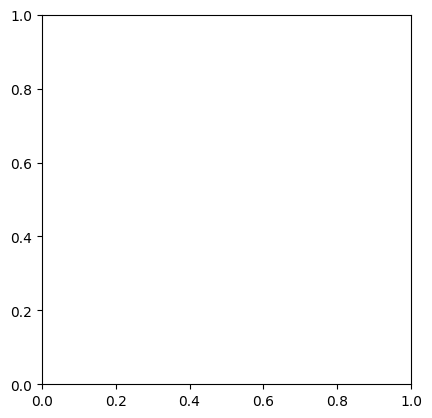

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#extent: floats (left, right, bottom, top)
im = plt.imshow(demd, cmap=plt.cm.viridis_r, extent=(min(bis), max(bis), min(wis), max(wis)),
                interpolation='bilinear')

plt.colorbar(im)
plt.title('Delta EMD\n$\\frac{\sum{}{}|\mathrm{EMD}_{Faulty} - \mathrm{EMD}_{Base}|}{\mathrm{V}}$')
plt.xlabel("Bit Index")
plt.ylabel("Weight Index")
plt.show()

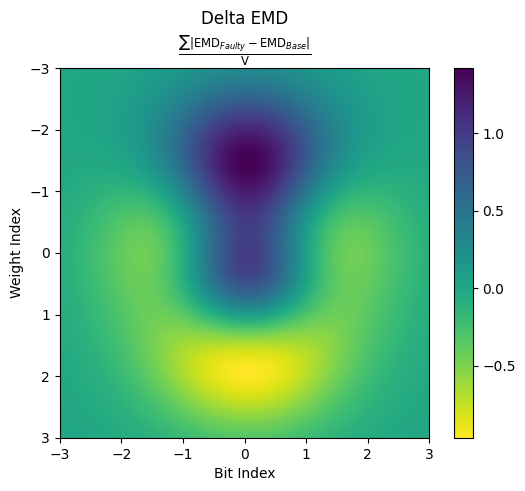

In [ ]:
# Mathematical function we need to plot
def z_func(x, y):
    return (1 - (x ** 2 + y ** 3)) * np.exp(-(x ** 2 + y ** 2) / 2)

# Setting up input values
x = np.arange(-3.0, 3.0, 0.1)
y = np.arange(-3.0, 3.0, 0.1)
X, Y = np.meshgrid(x, y)

# Calculating the output and storing it in the array Z
Z = z_func(X, Y)

im = plt.imshow(Z, cmap=plt.cm.viridis_r, extent=(-3, 3, 3, -3),
                interpolation='bilinear')

plt.colorbar(im)
plt.title('Delta EMD\n$\\frac{\sum{}{}|\mathrm{EMD}_{Faulty} - \mathrm{EMD}_{Base}|}{\mathrm{V}}$')
plt.xlabel("Bit Index")
plt.ylabel("Weight Index")
plt.show()

In [ ]:
print(x.shape)

(60,)


In [ ]:
print(Z.shape)

(60, 60)


In [ ]:
np.array()

array([[0, 1, 2, ..., 0, 1, 2],
       [0, 1, 2, ..., 0, 1, 2],
       [0, 1, 2, ..., 0, 1, 2],
       ...,
       [0, 1, 2, ..., 0, 1, 2],
       [0, 1, 2, ..., 0, 1, 2],
       [0, 1, 2, ..., 0, 1, 2]])

In [43]:
np.array([[1,2,3,4], [1,2,3,4], [1,2,3,4]])

array([[1, 2, 3, 4],
       [1, 2, 3, 4],
       [1, 2, 3, 4]])

In [45]:
x.shape

(395, 5)

In [46]:
y.shape

(395, 5)

In [47]:
len(demd)

1973

In [49]:
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]

1973

In [46]:
24*3

72

In [ ]:
(0, 360), <fkeras.fconvolutional.FQConv2D object at 0x7fda28662110>), ((360, 10600

In [47]:
72*5

360

In [49]:
(10600-360)/5

2048.0

In [51]:
(2048+72)*5

10600

In [24]:
10600/5

2120.0